# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

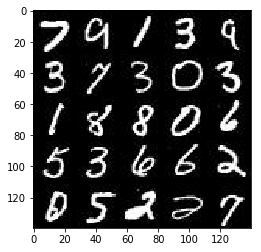

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

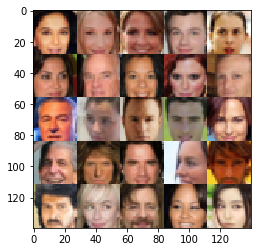

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_input = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return real_input_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.02
        
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        conv1 = tf.maximum(alpha * conv1, conv1)
        #14x14x64
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        #7x7x128
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        #4x4x256
        
        #flatten 
        flat = tf.reshape(conv3, [-1, 4*4*256])
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        

    return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    
    
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.02
        
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #7x7x512
        
        conv1 = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        #14x14x256
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        #28x28x128
        
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, padding='same', kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        #28x28xout_channel_dim
        
        output = tf.tanh(logits)
        
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits_real,
                                                labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
                                 
    
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    
    with tf.control_dependencies(d_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], len(data_image_mode), z_dim)
    
    l_rate = learning_rate
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                step += 1
                
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
                
                #sample random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)) 
                
                #Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z})
                
                _ = sess.run(g_opt, feed_dict={input_z:batch_z})
                
                _ = sess.run(g_opt, feed_dict={input_z:batch_z})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z})
                
                if step % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if step % 100 == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.4511... Generator Loss: 0.4843
Epoch 1/2... Discriminator Loss: 3.0664... Generator Loss: 0.1622
Epoch 1/2... Discriminator Loss: 3.0043... Generator Loss: 0.1020
Epoch 1/2... Discriminator Loss: 2.5050... Generator Loss: 0.2348
Epoch 1/2... Discriminator Loss: 2.0257... Generator Loss: 0.8797
Epoch 1/2... Discriminator Loss: 2.2316... Generator Loss: 0.3738
Epoch 1/2... Discriminator Loss: 1.9668... Generator Loss: 0.3842
Epoch 1/2... Discriminator Loss: 2.0328... Generator Loss: 0.4848
Epoch 1/2... Discriminator Loss: 1.9297... Generator Loss: 0.4715
Epoch 1/2... Discriminator Loss: 1.8857... Generator Loss: 0.4615


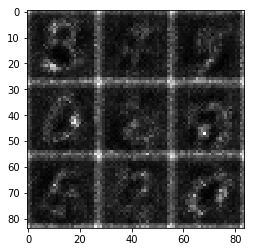

Epoch 1/2... Discriminator Loss: 1.8512... Generator Loss: 0.5241
Epoch 1/2... Discriminator Loss: 1.7476... Generator Loss: 0.3469
Epoch 1/2... Discriminator Loss: 2.0820... Generator Loss: 0.1700
Epoch 1/2... Discriminator Loss: 1.7269... Generator Loss: 0.3170
Epoch 1/2... Discriminator Loss: 2.0071... Generator Loss: 0.1851
Epoch 1/2... Discriminator Loss: 1.8059... Generator Loss: 0.2736
Epoch 1/2... Discriminator Loss: 2.0400... Generator Loss: 0.1741
Epoch 1/2... Discriminator Loss: 1.9134... Generator Loss: 0.2124
Epoch 1/2... Discriminator Loss: 2.0271... Generator Loss: 0.1858
Epoch 1/2... Discriminator Loss: 1.8122... Generator Loss: 0.2250


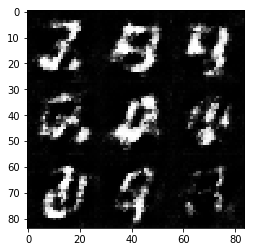

Epoch 1/2... Discriminator Loss: 1.9675... Generator Loss: 0.1973
Epoch 1/2... Discriminator Loss: 1.5894... Generator Loss: 0.4280
Epoch 1/2... Discriminator Loss: 1.7238... Generator Loss: 0.5385
Epoch 1/2... Discriminator Loss: 1.5296... Generator Loss: 0.7242
Epoch 1/2... Discriminator Loss: 1.8889... Generator Loss: 0.2620
Epoch 1/2... Discriminator Loss: 1.7874... Generator Loss: 0.3897
Epoch 1/2... Discriminator Loss: 1.5592... Generator Loss: 0.6099
Epoch 1/2... Discriminator Loss: 1.8027... Generator Loss: 0.6613
Epoch 1/2... Discriminator Loss: 1.6665... Generator Loss: 0.5866
Epoch 1/2... Discriminator Loss: 1.7829... Generator Loss: 0.3901


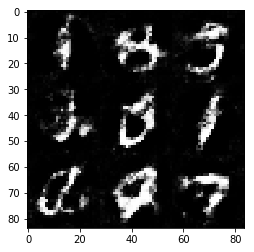

Epoch 1/2... Discriminator Loss: 1.9013... Generator Loss: 0.5478
Epoch 1/2... Discriminator Loss: 1.7405... Generator Loss: 0.4223
Epoch 1/2... Discriminator Loss: 1.9392... Generator Loss: 0.2380
Epoch 1/2... Discriminator Loss: 2.1612... Generator Loss: 0.1586
Epoch 1/2... Discriminator Loss: 2.0180... Generator Loss: 0.2025
Epoch 1/2... Discriminator Loss: 2.0842... Generator Loss: 0.1816
Epoch 1/2... Discriminator Loss: 1.8348... Generator Loss: 0.3174
Epoch 1/2... Discriminator Loss: 1.7984... Generator Loss: 0.5432
Epoch 1/2... Discriminator Loss: 1.8724... Generator Loss: 0.3768
Epoch 1/2... Discriminator Loss: 1.8674... Generator Loss: 0.2763


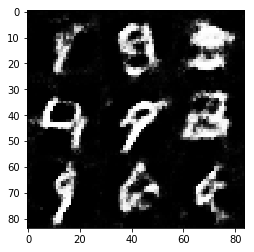

Epoch 1/2... Discriminator Loss: 1.9420... Generator Loss: 0.2063
Epoch 1/2... Discriminator Loss: 1.9738... Generator Loss: 0.2262
Epoch 1/2... Discriminator Loss: 2.1643... Generator Loss: 0.1596
Epoch 1/2... Discriminator Loss: 1.9615... Generator Loss: 0.2043
Epoch 1/2... Discriminator Loss: 1.8174... Generator Loss: 0.2736
Epoch 1/2... Discriminator Loss: 1.7761... Generator Loss: 0.3541
Epoch 1/2... Discriminator Loss: 1.9815... Generator Loss: 0.2067
Epoch 1/2... Discriminator Loss: 1.8732... Generator Loss: 0.2555
Epoch 1/2... Discriminator Loss: 1.7153... Generator Loss: 0.3500
Epoch 1/2... Discriminator Loss: 1.7465... Generator Loss: 0.4719


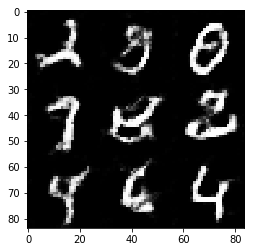

Epoch 1/2... Discriminator Loss: 1.7688... Generator Loss: 0.3645
Epoch 1/2... Discriminator Loss: 1.6903... Generator Loss: 0.6680
Epoch 1/2... Discriminator Loss: 1.7786... Generator Loss: 0.5384
Epoch 1/2... Discriminator Loss: 1.7675... Generator Loss: 0.3641
Epoch 1/2... Discriminator Loss: 1.9874... Generator Loss: 0.2069
Epoch 1/2... Discriminator Loss: 1.8398... Generator Loss: 0.2628
Epoch 1/2... Discriminator Loss: 1.8420... Generator Loss: 0.2699
Epoch 1/2... Discriminator Loss: 2.0063... Generator Loss: 0.1944
Epoch 1/2... Discriminator Loss: 1.9207... Generator Loss: 0.2201
Epoch 1/2... Discriminator Loss: 1.7256... Generator Loss: 0.3647


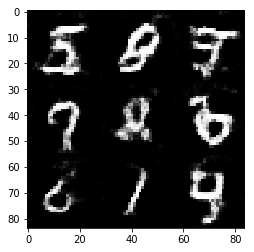

Epoch 1/2... Discriminator Loss: 1.6863... Generator Loss: 0.5450
Epoch 1/2... Discriminator Loss: 1.6486... Generator Loss: 0.4505
Epoch 1/2... Discriminator Loss: 1.7070... Generator Loss: 0.4912
Epoch 1/2... Discriminator Loss: 1.7812... Generator Loss: 0.4099
Epoch 1/2... Discriminator Loss: 1.6435... Generator Loss: 0.4709
Epoch 1/2... Discriminator Loss: 1.7853... Generator Loss: 0.3617
Epoch 1/2... Discriminator Loss: 1.6464... Generator Loss: 0.6428
Epoch 1/2... Discriminator Loss: 1.6891... Generator Loss: 0.4877
Epoch 1/2... Discriminator Loss: 1.6667... Generator Loss: 0.4332
Epoch 1/2... Discriminator Loss: 1.8143... Generator Loss: 0.5284


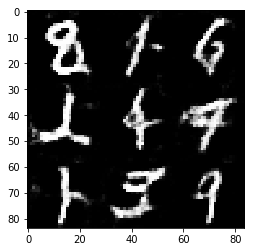

Epoch 1/2... Discriminator Loss: 1.6163... Generator Loss: 0.5332
Epoch 1/2... Discriminator Loss: 1.7256... Generator Loss: 0.5427
Epoch 1/2... Discriminator Loss: 1.9210... Generator Loss: 0.2275
Epoch 1/2... Discriminator Loss: 1.9368... Generator Loss: 0.2286
Epoch 1/2... Discriminator Loss: 1.7367... Generator Loss: 0.2858
Epoch 1/2... Discriminator Loss: 1.6874... Generator Loss: 0.4553
Epoch 1/2... Discriminator Loss: 1.9631... Generator Loss: 0.2072
Epoch 1/2... Discriminator Loss: 1.7034... Generator Loss: 0.3323
Epoch 1/2... Discriminator Loss: 1.7604... Generator Loss: 0.4998
Epoch 1/2... Discriminator Loss: 1.7602... Generator Loss: 0.3622


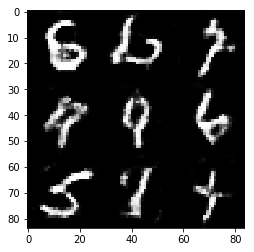

Epoch 1/2... Discriminator Loss: 1.7520... Generator Loss: 0.6381
Epoch 1/2... Discriminator Loss: 1.5724... Generator Loss: 0.5339
Epoch 1/2... Discriminator Loss: 1.7008... Generator Loss: 0.6516
Epoch 1/2... Discriminator Loss: 1.7186... Generator Loss: 0.4002
Epoch 1/2... Discriminator Loss: 1.6199... Generator Loss: 0.5093
Epoch 1/2... Discriminator Loss: 1.7003... Generator Loss: 0.3855
Epoch 1/2... Discriminator Loss: 1.7443... Generator Loss: 0.6020
Epoch 1/2... Discriminator Loss: 1.7561... Generator Loss: 0.6267
Epoch 1/2... Discriminator Loss: 1.7438... Generator Loss: 0.4565
Epoch 1/2... Discriminator Loss: 1.7528... Generator Loss: 0.3223


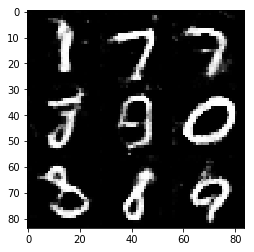

Epoch 1/2... Discriminator Loss: 1.8165... Generator Loss: 0.6950
Epoch 1/2... Discriminator Loss: 1.5920... Generator Loss: 0.4967
Epoch 1/2... Discriminator Loss: 1.6567... Generator Loss: 0.4529
Epoch 2/2... Discriminator Loss: 1.7889... Generator Loss: 0.2795
Epoch 2/2... Discriminator Loss: 1.8352... Generator Loss: 0.2622
Epoch 2/2... Discriminator Loss: 1.9531... Generator Loss: 0.2083
Epoch 2/2... Discriminator Loss: 1.8611... Generator Loss: 0.2450
Epoch 2/2... Discriminator Loss: 1.5939... Generator Loss: 0.4749
Epoch 2/2... Discriminator Loss: 1.7745... Generator Loss: 0.4263
Epoch 2/2... Discriminator Loss: 1.7750... Generator Loss: 0.4183


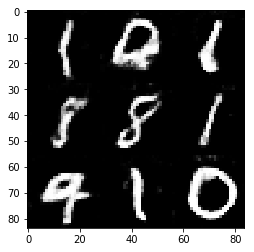

Epoch 2/2... Discriminator Loss: 1.6816... Generator Loss: 0.7273
Epoch 2/2... Discriminator Loss: 1.7554... Generator Loss: 0.3230
Epoch 2/2... Discriminator Loss: 1.8067... Generator Loss: 0.2729
Epoch 2/2... Discriminator Loss: 2.1152... Generator Loss: 0.1608
Epoch 2/2... Discriminator Loss: 1.8906... Generator Loss: 0.2314
Epoch 2/2... Discriminator Loss: 1.9821... Generator Loss: 0.2081
Epoch 2/2... Discriminator Loss: 1.7679... Generator Loss: 0.5084
Epoch 2/2... Discriminator Loss: 1.7064... Generator Loss: 0.4139
Epoch 2/2... Discriminator Loss: 1.8954... Generator Loss: 0.2112
Epoch 2/2... Discriminator Loss: 1.9211... Generator Loss: 0.2217


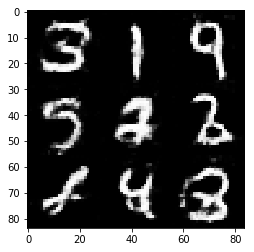

Epoch 2/2... Discriminator Loss: 1.7664... Generator Loss: 0.2879
Epoch 2/2... Discriminator Loss: 1.7657... Generator Loss: 0.2784
Epoch 2/2... Discriminator Loss: 2.2443... Generator Loss: 0.1385
Epoch 2/2... Discriminator Loss: 1.8554... Generator Loss: 0.2343
Epoch 2/2... Discriminator Loss: 1.7428... Generator Loss: 0.4894
Epoch 2/2... Discriminator Loss: 1.7163... Generator Loss: 0.3738
Epoch 2/2... Discriminator Loss: 1.6481... Generator Loss: 0.4104
Epoch 2/2... Discriminator Loss: 1.6016... Generator Loss: 0.5911
Epoch 2/2... Discriminator Loss: 1.7946... Generator Loss: 0.2852
Epoch 2/2... Discriminator Loss: 1.6482... Generator Loss: 0.5773


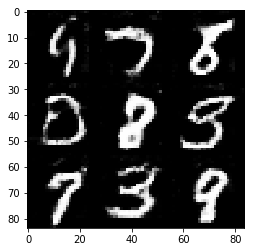

Epoch 2/2... Discriminator Loss: 1.7315... Generator Loss: 0.3546
Epoch 2/2... Discriminator Loss: 1.7546... Generator Loss: 0.3022
Epoch 2/2... Discriminator Loss: 1.9499... Generator Loss: 0.2252
Epoch 2/2... Discriminator Loss: 2.4296... Generator Loss: 0.1084
Epoch 2/2... Discriminator Loss: 1.6314... Generator Loss: 0.4633
Epoch 2/2... Discriminator Loss: 1.6273... Generator Loss: 0.4447
Epoch 2/2... Discriminator Loss: 1.6331... Generator Loss: 0.4531
Epoch 2/2... Discriminator Loss: 1.8276... Generator Loss: 0.3631
Epoch 2/2... Discriminator Loss: 1.9439... Generator Loss: 0.2095
Epoch 2/2... Discriminator Loss: 1.9532... Generator Loss: 0.2164


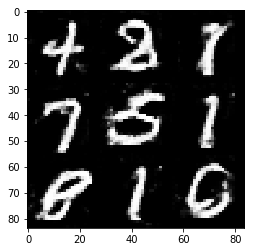

Epoch 2/2... Discriminator Loss: 1.8527... Generator Loss: 0.2429
Epoch 2/2... Discriminator Loss: 1.8563... Generator Loss: 0.2376
Epoch 2/2... Discriminator Loss: 1.8325... Generator Loss: 0.3428
Epoch 2/2... Discriminator Loss: 1.6085... Generator Loss: 0.6699
Epoch 2/2... Discriminator Loss: 1.7522... Generator Loss: 0.3350
Epoch 2/2... Discriminator Loss: 2.1879... Generator Loss: 0.1477
Epoch 2/2... Discriminator Loss: 1.8902... Generator Loss: 0.2346
Epoch 2/2... Discriminator Loss: 2.0331... Generator Loss: 0.1784
Epoch 2/2... Discriminator Loss: 1.8991... Generator Loss: 0.2164
Epoch 2/2... Discriminator Loss: 1.7766... Generator Loss: 0.3478


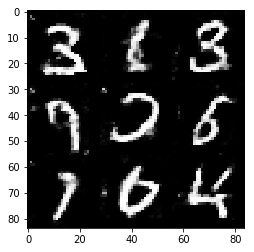

Epoch 2/2... Discriminator Loss: 1.7509... Generator Loss: 0.3676
Epoch 2/2... Discriminator Loss: 1.6582... Generator Loss: 0.3448
Epoch 2/2... Discriminator Loss: 2.9015... Generator Loss: 0.0659
Epoch 2/2... Discriminator Loss: 1.7079... Generator Loss: 0.3093
Epoch 2/2... Discriminator Loss: 1.7218... Generator Loss: 0.3051
Epoch 2/2... Discriminator Loss: 1.6705... Generator Loss: 0.3721
Epoch 2/2... Discriminator Loss: 1.6877... Generator Loss: 0.5328
Epoch 2/2... Discriminator Loss: 1.6355... Generator Loss: 0.4045
Epoch 2/2... Discriminator Loss: 1.7127... Generator Loss: 0.6721
Epoch 2/2... Discriminator Loss: 1.6779... Generator Loss: 0.3889


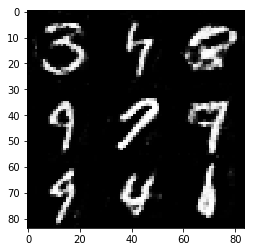

Epoch 2/2... Discriminator Loss: 1.8558... Generator Loss: 0.2596
Epoch 2/2... Discriminator Loss: 1.6760... Generator Loss: 0.3392
Epoch 2/2... Discriminator Loss: 1.9191... Generator Loss: 0.2180
Epoch 2/2... Discriminator Loss: 2.2226... Generator Loss: 0.1470
Epoch 2/2... Discriminator Loss: 1.7440... Generator Loss: 0.3159
Epoch 2/2... Discriminator Loss: 1.8476... Generator Loss: 0.2464
Epoch 2/2... Discriminator Loss: 1.6943... Generator Loss: 0.3099
Epoch 2/2... Discriminator Loss: 1.6209... Generator Loss: 0.5663
Epoch 2/2... Discriminator Loss: 1.7547... Generator Loss: 0.3156
Epoch 2/2... Discriminator Loss: 1.6094... Generator Loss: 0.5610


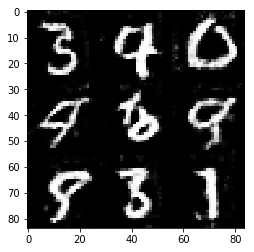

Epoch 2/2... Discriminator Loss: 1.6646... Generator Loss: 0.5613
Epoch 2/2... Discriminator Loss: 1.8370... Generator Loss: 0.3763
Epoch 2/2... Discriminator Loss: 1.6930... Generator Loss: 0.3576
Epoch 2/2... Discriminator Loss: 1.6640... Generator Loss: 0.4051
Epoch 2/2... Discriminator Loss: 1.6797... Generator Loss: 0.5759
Epoch 2/2... Discriminator Loss: 1.6331... Generator Loss: 0.4126
Epoch 2/2... Discriminator Loss: 1.7219... Generator Loss: 0.2997
Epoch 2/2... Discriminator Loss: 1.6873... Generator Loss: 0.3863
Epoch 2/2... Discriminator Loss: 1.8824... Generator Loss: 0.2246
Epoch 2/2... Discriminator Loss: 1.8756... Generator Loss: 0.2188


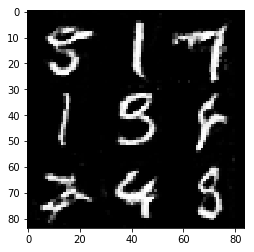

Epoch 2/2... Discriminator Loss: 1.9595... Generator Loss: 0.1971
Epoch 2/2... Discriminator Loss: 2.0174... Generator Loss: 0.1863
Epoch 2/2... Discriminator Loss: 1.7263... Generator Loss: 0.3652
Epoch 2/2... Discriminator Loss: 1.6476... Generator Loss: 0.4793
Epoch 2/2... Discriminator Loss: 1.6727... Generator Loss: 0.3616
Epoch 2/2... Discriminator Loss: 1.6511... Generator Loss: 0.3683
Epoch 2/2... Discriminator Loss: 1.5599... Generator Loss: 0.7179
Epoch 2/2... Discriminator Loss: 1.5964... Generator Loss: 0.5053
Epoch 2/2... Discriminator Loss: 1.6325... Generator Loss: 0.3561
Epoch 2/2... Discriminator Loss: 1.6798... Generator Loss: 0.3713


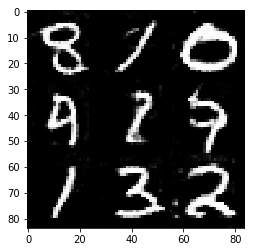

Epoch 2/2... Discriminator Loss: 1.5984... Generator Loss: 0.4338
Epoch 2/2... Discriminator Loss: 1.9370... Generator Loss: 0.2056
Epoch 2/2... Discriminator Loss: 1.3363... Generator Loss: 0.4356
Epoch 2/2... Discriminator Loss: 1.7321... Generator Loss: 0.3055
Epoch 2/2... Discriminator Loss: 1.7926... Generator Loss: 0.2792
Epoch 2/2... Discriminator Loss: 1.7043... Generator Loss: 0.2885
Epoch 2/2... Discriminator Loss: 2.0156... Generator Loss: 0.1842


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.9110... Generator Loss: 0.1998
Epoch 1/1... Discriminator Loss: 2.4748... Generator Loss: 1.2137
Epoch 1/1... Discriminator Loss: 2.0364... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.6778... Generator Loss: 1.3476
Epoch 1/1... Discriminator Loss: 1.6675... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 1.8560... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 2.1134... Generator Loss: 0.5426
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 2.1888... Generator Loss: 0.1712
Epoch 1/1... Discriminator Loss: 1.8511... Generator Loss: 0.3438


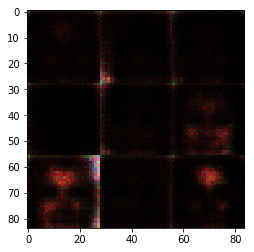

Epoch 1/1... Discriminator Loss: 1.9086... Generator Loss: 0.5618
Epoch 1/1... Discriminator Loss: 1.7995... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.6335... Generator Loss: 0.4752
Epoch 1/1... Discriminator Loss: 1.9301... Generator Loss: 0.4318
Epoch 1/1... Discriminator Loss: 1.9586... Generator Loss: 0.2317
Epoch 1/1... Discriminator Loss: 2.0191... Generator Loss: 0.2314
Epoch 1/1... Discriminator Loss: 1.7313... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.5405... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 1.0103
Epoch 1/1... Discriminator Loss: 1.5705... Generator Loss: 0.4640


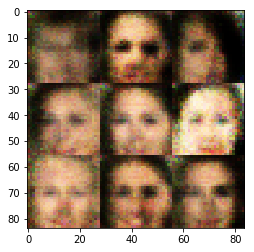

Epoch 1/1... Discriminator Loss: 1.6650... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 1.0999
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.6009... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.6556... Generator Loss: 0.5501
Epoch 1/1... Discriminator Loss: 1.6540... Generator Loss: 0.4413
Epoch 1/1... Discriminator Loss: 1.7431... Generator Loss: 0.3453
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.5903... Generator Loss: 0.5336


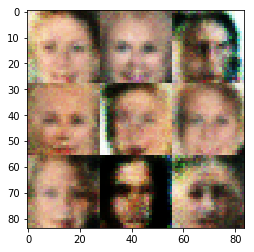

Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.6036... Generator Loss: 0.4748
Epoch 1/1... Discriminator Loss: 1.6514... Generator Loss: 0.4302
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.5901... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.5881... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.5505... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.5674... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.7052


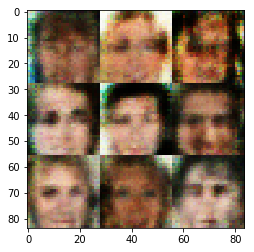

Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.5305... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.6217


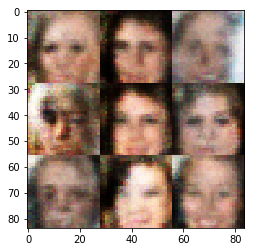

Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.6408


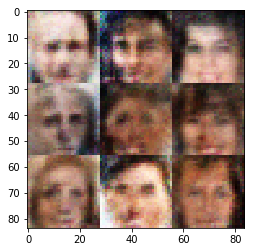

Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.5888


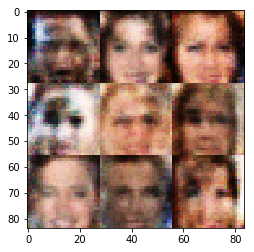

Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6530


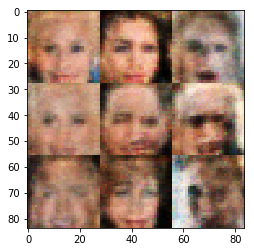

Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.6422


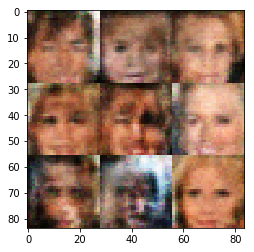

Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.6971


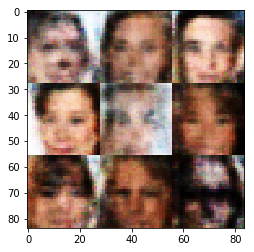

Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.6306


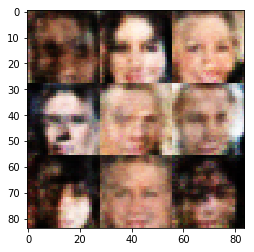

Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.6955


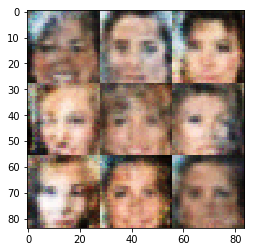

KeyboardInterrupt: 

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.